In [1]:
import re
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# TODO make sure these are all correct before running this notebook !!!

# True if you want to parse password manager results, False if you want to parse family app results
pass_bmark = True

# Check [num] at the end of each directory
if pass_bmark:
    subdir = "update_pass_data_0"
else:
    subdir = "edit_post_data_0"

# Check num warmup and runs is correct
warmup_count = 1000
runs_count = 10000

In [3]:
if pass_bmark:
    enterapp = "enter update"
else:
    enterapp = "enter edit"
entertank = "enter TANK"
exittank = "exit TANK"
if pass_bmark:
    exitapp = "exit update"
    exitapp = "exit edit"

def get_app_overheads(filename, num_warmup):
    app_send_dur = []
    app_recv_dur = []

    with open(filename) as f:
        tmp = 0
        ctr = 0
        line = f.readline()
        while (line):
            # every four lines is a new run
            ctr += 1
            if ctr <= num_warmup:
                continue
            
            match = re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )
            if (match): 
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))

                if level == enterapp:
                    tmp = timestamp
                elif level == entertank:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    app_send_dur.append(dur)
                elif level == exittank:
                    tmp = timestamp
                else:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    app_recv_dur.append(dur)
                    
                
            line = f.readline()
            
        print("ctr: ", ctr)
        print("counted: ", ctr - num_warmup)

    return app_send_dur, app_recv_dur

In [4]:
enterpovs = "enter POVS"
entersymenc = "enter SYMENC"
entersessenc = "enter SESSENC"
exitcore = "exit CORE"

def get_core_send_overheads(filename, num_core_send_warmup):
    pov_send_dur = []
    symenc_send_dur = []
    sessenc_send_dur = []

    with open(filename) as f:
        tmp = 0
        ctr = 0
        pov_run = []
        symenc_run = []
        sessenc_run = []
        
        line = f.readline()
        while (line):
            # every 4 lines is a new message
            ctr += 1
            if ctr <= num_core_send_warmup:
                continue
                
            match = re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )
            if (match):
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))

                # every 8 lines is a new run
                mod = ctr % 8
                if mod == 0:
                    # pov
                    pov_dur = 0
                    for part in pov_run:
                        pov_dur += part
                    pov_send_dur.append(pov_dur)
                    pov_run = []
                    # sym enc
                    symenc_dur = 0
                    for part in symenc_run:
                        symenc_dur += part
                    symenc_send_dur.append(symenc_dur)
                    symenc_run = []
                    # sess enc
                    sessenc_dur = 0
                    for part in sessenc_run:
                        sessenc_dur += part
                    sessenc_send_dur.append(sessenc_dur)
                    sessenc_run = []

                if level == enterpovs:
                    tmp = timestamp
                elif level == entersymenc:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    pov_run.append(dur)
                    tmp = timestamp
                elif level == entersessenc:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    symenc_run.append(dur)
                    tmp = timestamp
                else:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    sessenc_run.append(dur)
                
            line = f.readline()
            
        print("ctr: ", ctr)
        print("counted: ", ctr - num_core_send_warmup)

    return pov_send_dur, symenc_send_dur, sessenc_send_dur

In [5]:
entersessdec = "enter SESSDECR"
entersymdec = "enter SYMDECR"
exitdec = "enter POVS"
exitcore = "exit CORE"

def get_core_recv_overheads(filename, num_core_recv_warmup):
    sessenc_recv_dur = []
    symenc_recv_dur = []
    pov_recv_dur = []

    with open(filename) as f:
        tmp = 0
        ctr = 0
        pov_run = []
        sessenc_run = []
        symenc_run = []
        
        line = f.readline()
        while (line):
            # every 4 lines is a new message
            ctr += 1
            if ctr <= num_core_recv_warmup:
                continue
                
            match = re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )
            if (match):
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))

                # every 8 lines is a new run
                mod = ctr % 8
                if mod == 0:
                    # pov
                    pov_dur = 0
                    for part in pov_run:
                        pov_dur += part
                    pov_recv_dur.append(pov_dur)
                    pov_run = []
                    # sym enc
                    symenc_dur = 0
                    for part in symenc_run:
                        symenc_dur += part
                    symenc_recv_dur.append(symenc_dur)
                    symenc_run = []
                    # sess enc
                    sessenc_dur = 0
                    for part in sessenc_run:
                        sessenc_dur += part
                    sessenc_recv_dur.append(sessenc_dur)
                    sessenc_run = []
            
                if level == entersessdec:
                    tmp = timestamp
                elif level == entersymdec:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    sessenc_run.append(dur)
                    tmp = timestamp
                elif level == exitdec:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    symenc_run.append(dur)
                    tmp = timestamp
                else:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    pov_run.append(dur)
                
            line = f.readline()
            
        print("ctr: ", ctr)
        print("counted: ", ctr - num_core_recv_warmup)

    return sessenc_recv_dur, symenc_recv_dur, pov_recv_dur

In [6]:
enter_send_tank = "enter sendTANK"
entercore = "enter CORE"
exitcore = "exit CORE"
exit_last_core = "exit LASTCORE"
exit_send_tank = "exit sendTANK"

def get_tank_send_overheads(filename, num_tank_send_warmup):
    tank_send_dur = []
    with open(filename) as f:
        tmp = 0
        ctr = 0
        run = []
        
        line = f.readline()
        while (line):
            ctr += 1
            if ctr <= num_tank_send_warmup:
                continue
            
            match = re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )
            if (match):
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))

                # every 6 lines is a new run
                mod = ctr % 6
                if mod == 0:
                    dur = 0
                    for part in run:
                        dur += part
                    tank_send_dur.append(dur)
                    run = []

                if level == enter_send_tank:
                    tmp = timestamp
                elif level == entercore:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    run.append(dur)
                elif level == exitcore:
                    tmp = timestamp
                elif level == exit_last_core:
                    tmp = timestamp
                else:
                    dur = timestamp - tmp
                    if dur < 0:
                        dur += 1000000000
                    run.append(dur)
                
            line = f.readline()
        print("ctr: ", ctr)
        print("counted: ", ctr - num_tank_send_warmup)

    return tank_send_dur

In [7]:
enter_recv_tank = "enter recvTANK"
exit_recv_tank = "exit recvTANK"

def get_tank_recv_overheads(filename_update, filename_dummy, num_tank_recv_warmup):
    tank_recv_dur_update = []
    with open(filename_update) as f:
        tmp = 0
        ctr = 0
        
        line = f.readline()
        while (line):
            ctr += 1
            if ctr <= num_tank_recv_warmup:
                continue
                
            match = re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )
            if (match):
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))

                if level == enter_recv_tank:
                    tmp = timestamp
                else:
                    dur = timestamp - tmp;
                    if dur < 0:
                        dur += 1000000000
                    tank_recv_dur_update.append(dur)
                
            line = f.readline()

    tank_recv_dur_dummy = []
    with open(filename_dummy) as f:
        tmp = 0
        ctr = 0
        
        line = f.readline()
        while (line):
            ctr += 1
            if ctr <= num_tank_recv_warmup:
                continue
                
            match = re.search(
                "(([0-9]+), \"([a-z]+ [a-zA-Z]+)\", Instant { tv_sec: [0-9]+, tv_nsec: ([0-9]+) })",
                line
            )
            if (match):
                run_ct = int(match.group(2))
                level = match.group(3)
                timestamp = int(match.group(4))
                
                if level == enter_recv_tank:
                    tmp = timestamp
                else:
                    dur = timestamp - tmp;
                    if dur < 0:
                        dur += 1000000000
                    tank_recv_dur_dummy.append(dur)
                
            line = f.readline()

    print(len(tank_recv_dur_update))
    print(len(tank_recv_dur_dummy))

    sum_tank_recv_dur = []
    for (update_dur, dummy_dur) in zip(tank_recv_dur_update, tank_recv_dur_dummy):
        sum_tank_recv_dur.append(update_dur + dummy_dur)

    return sum_tank_recv_dur

In [8]:
def app_filename(num_clients, num_runs):
    return "./{}/{}c_{}r_ts_app.txt".format(subdir, num_clients, num_runs)

def tank_send_filename(num_clients, num_runs):
    return "./{}/{}c_{}r_ts_tank_send.txt".format(subdir, num_clients, num_runs)

def tank_recv_filename_update(num_clients, num_runs):
    return "./{}/{}c_{}r_ts_tank_recv_update.txt".format(subdir, num_clients, num_runs)

def tank_recv_filename_dummy(num_clients, num_runs):
    return "./{}/{}c_{}r_ts_tank_recv_dummy.txt".format(subdir, num_clients, num_runs)

def core_send_filename(num_clients, num_runs):
    return "./{}/{}c_{}r_ts_core_send.txt".format(subdir, num_clients, num_runs)

def core_recv_filename(num_clients, num_runs):
    return "./{}/{}c_{}r_ts_core_recv.txt".format(subdir, num_clients, num_runs)


In [9]:
# test

In [10]:
clients_count = 4

app_send_dur_0, app_recv_dur_0 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
tank_send_dur_0 = get_tank_send_overheads(tank_send_filename(clients_count, runs_count), 6 * warmup_count)
tank_recv_dur_0 = get_tank_recv_overheads(tank_recv_filename_update(clients_count, runs_count), tank_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_0, symenc_send_dur_0, sessenc_send_dur_0 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_0, symenc_recv_dur_0, pov_recv_dur_0 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  48000
counted:  44000
ctr:  72000
counted:  66000
11000
11000
ctr:  96000
counted:  88000
ctr:  96000
counted:  88000


In [11]:
print(mean(symenc_send_dur_0))
print(mean(sessenc_send_dur_0))
print(mean(pov_send_dur_0))
print(mean(tank_send_dur_0))
print(mean(app_send_dur_0))

480141.81254545454
6750215.174454546
36350.252636363635
22047.123454545454
4369.854909090909


<function matplotlib.pyplot.show(close=None, block=None)>

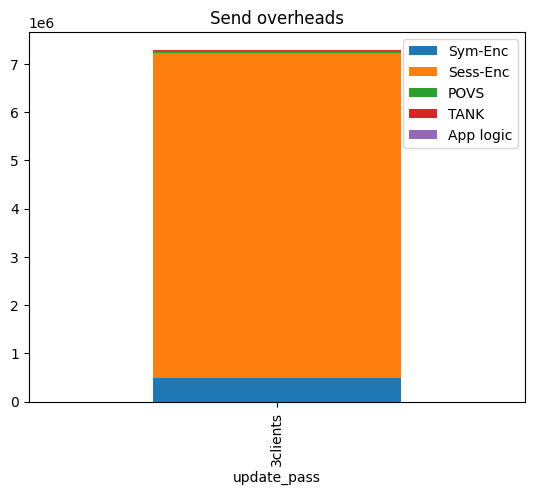

In [12]:
df = pd.DataFrame([
    ["3clients", mean(symenc_send_dur_0), mean(sessenc_send_dur_0), mean(pov_send_dur_0), mean(tank_send_dur_0), mean(app_send_dur_0)],
], columns=["update_pass", "Sym-Enc", "Sess-Enc", "POVS", "TANK", "App logic"])
df.plot(x='update_pass', kind='bar', stacked=True, title='Send overheads')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

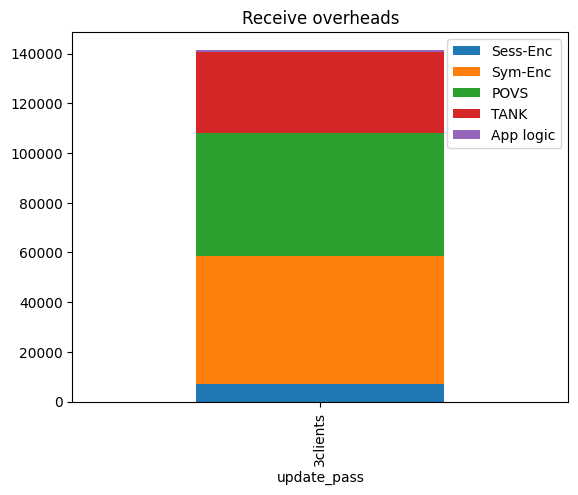

In [13]:
df = pd.DataFrame([
    ["3clients", mean(sessenc_recv_dur_0), mean(symenc_recv_dur_0), mean(pov_recv_dur_0), mean(tank_recv_dur_0), mean(app_recv_dur_0)],
], columns=["update_pass", "Sess-Enc", "Sym-Enc", "POVS", "TANK", "App logic"])
df.plot(x='update_pass', kind='bar', stacked=True, title='Receive overheads')
plt.show

In [14]:
# real data

In [15]:
clients_count = 1

app_send_dur_0, app_recv_dur_0 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
tank_send_dur_0 = get_tank_send_overheads(tank_send_filename(clients_count, runs_count), 6 * warmup_count)
tank_recv_dur_0 = get_tank_recv_overheads(tank_recv_filename_update(clients_count, runs_count), tank_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_0, symenc_send_dur_0, sessenc_send_dur_0 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_0, symenc_recv_dur_0, pov_recv_dur_0 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  48000
counted:  44000
ctr:  72000
counted:  66000
11000
11000
ctr:  96000
counted:  88000
ctr:  96000
counted:  88000


In [16]:
clients_count = 2

app_send_dur_1, app_recv_dur_1 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
tank_send_dur_1 = get_tank_send_overheads(tank_send_filename(clients_count, runs_count), 6 * warmup_count)
tank_recv_dur_1 = get_tank_recv_overheads(tank_recv_filename_update(clients_count, runs_count), tank_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_1, symenc_send_dur_1, sessenc_send_dur_1 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_1, symenc_recv_dur_1, pov_recv_dur_1 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  48000
counted:  44000
ctr:  72000
counted:  66000
11000
11000
ctr:  96000
counted:  88000
ctr:  96000
counted:  88000


In [17]:
clients_count = 4

app_send_dur_2, app_recv_dur_2 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
tank_send_dur_2 = get_tank_send_overheads(tank_send_filename(clients_count, runs_count), 6 * warmup_count)
tank_recv_dur_2 = get_tank_recv_overheads(tank_recv_filename_update(clients_count, runs_count), tank_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_2, symenc_send_dur_2, sessenc_send_dur_2 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_2, symenc_recv_dur_2, pov_recv_dur_2 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  48000
counted:  44000
ctr:  72000
counted:  66000
11000
11000
ctr:  96000
counted:  88000
ctr:  96000
counted:  88000


In [18]:
clients_count = 8

app_send_dur_4, app_recv_dur_4 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
tank_send_dur_4 = get_tank_send_overheads(tank_send_filename(clients_count, runs_count), 6 * warmup_count)
tank_recv_dur_4 = get_tank_recv_overheads(tank_recv_filename_update(clients_count, runs_count), tank_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_4, symenc_send_dur_4, sessenc_send_dur_4 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_4, symenc_recv_dur_4, pov_recv_dur_4 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  48000
counted:  44000
ctr:  72000
counted:  66000
11000
11000
ctr:  96000
counted:  88000
ctr:  96000
counted:  88000


In [19]:
clients_count = 16

app_send_dur_5, app_recv_dur_5 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
tank_send_dur_5 = get_tank_send_overheads(tank_send_filename(clients_count, runs_count), 6 * warmup_count)
tank_recv_dur_5 = get_tank_recv_overheads(tank_recv_filename_update(clients_count, runs_count), tank_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_5, symenc_send_dur_5, sessenc_send_dur_5 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_5, symenc_recv_dur_5, pov_recv_dur_5 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  48000
counted:  44000
ctr:  72000
counted:  66000
11000
11000
ctr:  96000
counted:  88000
ctr:  96000
counted:  88000


In [20]:
clients_count = 32

app_send_dur_6, app_recv_dur_6 = get_app_overheads(app_filename(clients_count, runs_count), 4 * warmup_count)
tank_send_dur_6 = get_tank_send_overheads(tank_send_filename(clients_count, runs_count), 6 * warmup_count)
tank_recv_dur_6 = get_tank_recv_overheads(tank_recv_filename_update(clients_count, runs_count), tank_recv_filename_dummy(clients_count, runs_count), 2 * warmup_count)
pov_send_dur_6, symenc_send_dur_6, sessenc_send_dur_6 = get_core_send_overheads(core_send_filename(clients_count, runs_count), 4 * 2 * warmup_count)
sessenc_recv_dur_6, symenc_recv_dur_6, pov_recv_dur_6 = get_core_recv_overheads(core_recv_filename(clients_count, runs_count), 4 * 2 * warmup_count)

ctr:  48000
counted:  44000
ctr:  72000
counted:  66000
11000
11000
ctr:  96000
counted:  88000
ctr:  96000
counted:  88000


In [21]:
ratio = 1000

symencsend_ms_0 = mean(symenc_send_dur_0) / ratio
symencsend_ms_1 = mean(symenc_send_dur_1) / ratio
symencsend_ms_2 = mean(symenc_send_dur_2) / ratio
symencsend_ms_4 = mean(symenc_send_dur_4) / ratio
symencsend_ms_5 = mean(symenc_send_dur_5) / ratio
symencsend_ms_6 = mean(symenc_send_dur_6) / ratio

encsend_ms_0 = mean(sessenc_send_dur_0) / ratio
encsend_ms_1 = mean(sessenc_send_dur_1) / ratio
encsend_ms_2 = mean(sessenc_send_dur_2) / ratio
encsend_ms_4 = mean(sessenc_send_dur_4) / ratio
encsend_ms_5 = mean(sessenc_send_dur_5) / ratio
encsend_ms_6 = mean(sessenc_send_dur_6) / ratio

povsend_ms_0 = mean(pov_send_dur_0) / ratio
povsend_ms_1 = mean(pov_send_dur_1) / ratio
povsend_ms_2 = mean(pov_send_dur_2) / ratio
povsend_ms_4 = mean(pov_send_dur_4) / ratio
povsend_ms_5 = mean(pov_send_dur_5) / ratio
povsend_ms_6 = mean(pov_send_dur_6) / ratio

tanksend_ms_0 = mean(tank_send_dur_0) / ratio
tanksend_ms_1 = mean(tank_send_dur_1) / ratio
tanksend_ms_2 = mean(tank_send_dur_2) / ratio
tanksend_ms_4 = mean(tank_send_dur_4) / ratio
tanksend_ms_5 = mean(tank_send_dur_5) / ratio
tanksend_ms_6 = mean(tank_send_dur_6) / ratio

appsend_ms_0 = mean(app_send_dur_0) / ratio
appsend_ms_1 = mean(app_send_dur_1) / ratio
appsend_ms_2 = mean(app_send_dur_2) / ratio
appsend_ms_4 = mean(app_send_dur_4) / ratio
appsend_ms_5 = mean(app_send_dur_5) / ratio
appsend_ms_6 = mean(app_send_dur_6) / ratio

sum0 = symencsend_ms_0 + encsend_ms_0 + povsend_ms_0 + tanksend_ms_0 + appsend_ms_0
sum1 = symencsend_ms_1 + encsend_ms_1 + povsend_ms_1 + tanksend_ms_1 + appsend_ms_1
sum2 = symencsend_ms_2 + encsend_ms_2 + povsend_ms_2 + tanksend_ms_2 + appsend_ms_2
sum4 = symencsend_ms_4 + encsend_ms_4 + povsend_ms_4 + tanksend_ms_4 + appsend_ms_4
sum5 = symencsend_ms_5 + encsend_ms_5 + povsend_ms_5 + tanksend_ms_5 + appsend_ms_5
sum6 = symencsend_ms_6 + encsend_ms_6 + povsend_ms_6 + tanksend_ms_6 + appsend_ms_6

max_send = max(sum0, sum1, sum2, sum4, sum5, sum6)
max_send

53411.66128809091

In [22]:
f = open("./{}/parsed_send_means.txt".format(subdir), "w")

f.write("Label\tsymenc\tsessenc\tpov\ttank\tapp\n")
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(1, symencsend_ms_0, encsend_ms_0, povsend_ms_0, tanksend_ms_0, appsend_ms_0))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(2, symencsend_ms_1, encsend_ms_1, povsend_ms_1, tanksend_ms_1, appsend_ms_1))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(4, symencsend_ms_2, encsend_ms_2, povsend_ms_2, tanksend_ms_2, appsend_ms_2))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(8, symencsend_ms_4, encsend_ms_4, povsend_ms_4, tanksend_ms_4, appsend_ms_4))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(16, symencsend_ms_5, encsend_ms_5, povsend_ms_5, tanksend_ms_5, appsend_ms_5))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(32, symencsend_ms_6, encsend_ms_6, povsend_ms_6, tanksend_ms_6, appsend_ms_6))
f.close()

In [23]:
# lefthand variable names say "send" but they really correspond to "recv" I just didn't want to rewrite all the var names (easier to copy/paste)
# FIXME putting all this data in a data structure without var names would be great...

encsend_ms_0 = mean(sessenc_recv_dur_0) / ratio
encsend_ms_1 = mean(sessenc_recv_dur_1) / ratio
encsend_ms_2 = mean(sessenc_recv_dur_2) / ratio
encsend_ms_4 = mean(sessenc_recv_dur_4) / ratio
encsend_ms_5 = mean(sessenc_recv_dur_5) / ratio
encsend_ms_6 = mean(sessenc_recv_dur_6) / ratio

symencsend_ms_0 = mean(symenc_recv_dur_0) / ratio
symencsend_ms_1 = mean(symenc_recv_dur_1) / ratio
symencsend_ms_2 = mean(symenc_recv_dur_2) / ratio
symencsend_ms_4 = mean(symenc_recv_dur_4) / ratio
symencsend_ms_5 = mean(symenc_recv_dur_5) / ratio
symencsend_ms_6 = mean(symenc_recv_dur_6) / ratio

povsend_ms_0 = mean(pov_recv_dur_0) / ratio
povsend_ms_1 = mean(pov_recv_dur_1) / ratio
povsend_ms_2 = mean(pov_recv_dur_2) / ratio
povsend_ms_4 = mean(pov_recv_dur_4) / ratio
povsend_ms_5 = mean(pov_recv_dur_5) / ratio
povsend_ms_6 = mean(pov_recv_dur_6) / ratio

tanksend_ms_0 = mean(tank_recv_dur_0) / ratio
tanksend_ms_1 = mean(tank_recv_dur_1) / ratio
tanksend_ms_2 = mean(tank_recv_dur_2) / ratio
tanksend_ms_4 = mean(tank_recv_dur_4) / ratio
tanksend_ms_5 = mean(tank_recv_dur_5) / ratio
tanksend_ms_6 = mean(tank_recv_dur_6) / ratio

appsend_ms_0 = mean(app_recv_dur_0) / ratio
appsend_ms_1 = mean(app_recv_dur_1) / ratio
appsend_ms_2 = mean(app_recv_dur_2) / ratio
appsend_ms_4 = mean(app_recv_dur_4) / ratio
appsend_ms_5 = mean(app_recv_dur_5) / ratio
appsend_ms_6 = mean(app_recv_dur_6) / ratio

sum0 = symencsend_ms_0 + encsend_ms_0 + povsend_ms_0 + tanksend_ms_0 + appsend_ms_0
sum1 = symencsend_ms_1 + encsend_ms_1 + povsend_ms_1 + tanksend_ms_1 + appsend_ms_1
sum2 = symencsend_ms_2 + encsend_ms_2 + povsend_ms_2 + tanksend_ms_2 + appsend_ms_2
sum4 = symencsend_ms_4 + encsend_ms_4 + povsend_ms_4 + tanksend_ms_4 + appsend_ms_4
sum5 = symencsend_ms_5 + encsend_ms_5 + povsend_ms_5 + tanksend_ms_5 + appsend_ms_5
sum6 = symencsend_ms_6 + encsend_ms_6 + povsend_ms_6 + tanksend_ms_6 + appsend_ms_6

max_send = max(sum0, sum1, sum2, sum4, sum5, sum6)
max_send

886.7938646363635

In [24]:
f = open("./{}/parsed_recv_means.txt".format(subdir), "w")

f.write("Label\tsymenc\tsessenc\tpov\ttank\tapp\n")
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(1, symencsend_ms_0, encsend_ms_0, povsend_ms_0, tanksend_ms_0, appsend_ms_0))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(2, symencsend_ms_1, encsend_ms_1, povsend_ms_1, tanksend_ms_1, appsend_ms_1))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(4, symencsend_ms_2, encsend_ms_2, povsend_ms_2, tanksend_ms_2, appsend_ms_2))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(8, symencsend_ms_4, encsend_ms_4, povsend_ms_4, tanksend_ms_4, appsend_ms_4))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(16, symencsend_ms_5, encsend_ms_5, povsend_ms_5, tanksend_ms_5, appsend_ms_5))
f.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(32, symencsend_ms_6, encsend_ms_6, povsend_ms_6, tanksend_ms_6, appsend_ms_6))
f.close()

<function matplotlib.pyplot.show(close=None, block=None)>

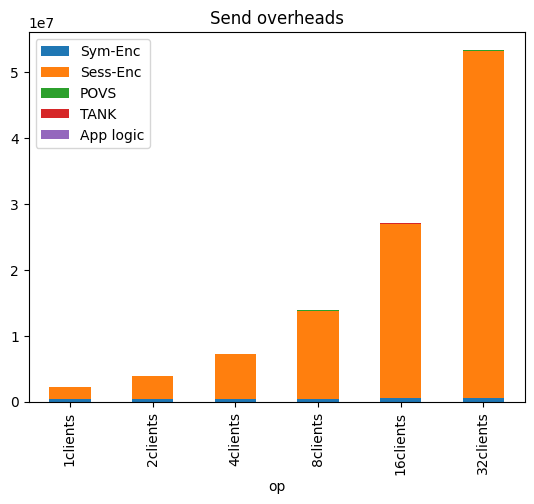

In [25]:
df = pd.DataFrame([
    ["1clients", mean(symenc_send_dur_0), mean(sessenc_send_dur_0), mean(pov_send_dur_0), mean(tank_send_dur_0), mean(app_send_dur_0)],
    ["2clients", mean(symenc_send_dur_1), mean(sessenc_send_dur_1), mean(pov_send_dur_1), mean(tank_send_dur_1), mean(app_send_dur_1)],
    ["4clients", mean(symenc_send_dur_2), mean(sessenc_send_dur_2), mean(pov_send_dur_2), mean(tank_send_dur_2), mean(app_send_dur_2)],
    ["8clients", mean(symenc_send_dur_4), mean(sessenc_send_dur_4), mean(pov_send_dur_4), mean(tank_send_dur_4), mean(app_send_dur_4)],
    ["16clients", mean(symenc_send_dur_5), mean(sessenc_send_dur_5), mean(pov_send_dur_5), mean(tank_send_dur_5), mean(app_send_dur_5)],
    ["32clients", mean(symenc_send_dur_6), mean(sessenc_send_dur_6), mean(pov_send_dur_6), mean(tank_send_dur_6), mean(app_send_dur_6)],
], columns=["op", "Sym-Enc", "Sess-Enc", "POVS", "TANK", "App logic"])
df.plot(x='op', kind='bar', stacked=True, title='Send overheads')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

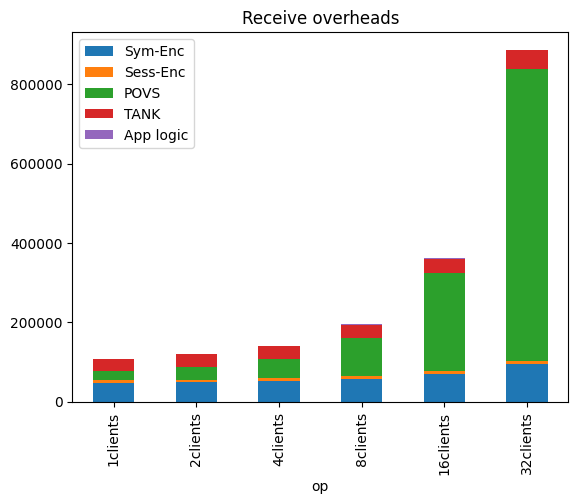

In [26]:
df = pd.DataFrame([
    ["1clients", mean(symenc_recv_dur_0), mean(sessenc_recv_dur_0), mean(pov_recv_dur_0), mean(tank_recv_dur_0), mean(app_recv_dur_0)],
    ["2clients", mean(symenc_recv_dur_1), mean(sessenc_recv_dur_1), mean(pov_recv_dur_1), mean(tank_recv_dur_1), mean(app_recv_dur_1)],
    ["4clients", mean(symenc_recv_dur_2), mean(sessenc_recv_dur_2), mean(pov_recv_dur_2), mean(tank_recv_dur_2), mean(app_recv_dur_2)],
    ["8clients", mean(symenc_recv_dur_4), mean(sessenc_recv_dur_4), mean(pov_recv_dur_4), mean(tank_recv_dur_4), mean(app_recv_dur_4)],
    ["16clients", mean(symenc_recv_dur_5), mean(sessenc_recv_dur_5), mean(pov_recv_dur_5), mean(tank_recv_dur_5), mean(app_recv_dur_5)],
    ["32clients", mean(symenc_recv_dur_6), mean(sessenc_recv_dur_6), mean(pov_recv_dur_6), mean(tank_recv_dur_6), mean(app_recv_dur_6)],
], columns=["op", "Sym-Enc", "Sess-Enc", "POVS", "TANK", "App logic"])
df.plot(x='op', kind='bar', stacked=True, title='Receive overheads')
plt.show